# Đánh giá mô hình Fine-tuned: MedMCQA (LoRA 4-bit)


## 1. Model & Training Summary

### 1.1 Thông tin mô hình
- `Kiến trúc`: LLaMA 3.2 1B

- `Kích thước`: 1B tham số

- `Định dạng`: 4-bit (bnb)

- `Kỹ thuật fine-tune`: PEFT + LoRA

- `Framework`: UnsLoTh + Hugging Face Transformers

### 1.2 Tham số huấn luyện
- `learning_rate`: 3e-4

- `lr_scheduler_type`: linear

- `batch_size`: 32

- `gradient_accumulation_steps`: 8

- `epochs`: 2

- `eval_steps`: 50

- `save_total_limit`: 1

- `optim`: adamw_8bit

- `fp16`: `True` / `False` (tùy GPU)

### 1.3 Thông tin dataset
- `Dataset`: openlifescienceai/medmcqa

- `Tập dùng huấn luyện`: train

- `Tập dùng đánh giá`: validation

- `Trường huấn luyện:` "text" – đã gộp question, opa, opb, opc, opd

- `Trường nhãn đúng (ground truth)`: "cop" – đáp án đúng: "A", "B", "C", "D"

## 2. Evaluation Objectives

- Đo độ chính xác (Accuracy) trên tập `validation`

- Phân tích Confusion Matrix giữa các lựa chọn `A–D` và `invalid`

- So sánh giữa `base model` và `fintuned model`

- Trích `classification_report` để đo Precision, Recall, F1 theo từng nhãn

- Phân tích lỗi chi tiết (câu hỏi nào sai, nhầm sang lựa chọn nào)

- Lưu và trình bày ví dụ dự đoán sai để kiểm tra thủ công

## 3. Setup & Utilities

### 3.1 import thư viện

In [2]:
from transformers import logging
from peft import PeftModel
import pandas as pd
logging.set_verbosity_error()
from transformers import AutoModelForCausalLM, AutoTokenizer

import re
from tqdm import tqdm
import evaluate
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset

f:\Parameter-Efficient-Fine-Tuning-For-ViMedMCQA\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 3.2 Load dữ liệu để đánh giá

In [3]:
ds = load_dataset("openlifescienceai/medmcqa", split="validation")

### 3.3 Load model đã fine-tune

In [4]:
model_path="dainlieu/Llama-3.2-3B-bnb-4bit-MedMCQA"

# Load base model (bnb-4bit)
base_model = AutoModelForCausalLM.from_pretrained(
    "unsloth/llama-3.2-3b-bnb-4bit",
    device_map="auto",               # cho dùng GPU
    load_in_4bit=True
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("unsloth/llama-3.2-3b-bnb-4bit")

# Load adapter (LoRA fine-tune)
model = PeftModel.from_pretrained(
    base_model,
    "dainlieu/Llama-3.2-3B-bnb-4bit-MedMCQA"
)

model.eval()

f:\Parameter-Efficient-Fine-Tuning-For-ViMedMCQA\venv\lib\site-packages\transformers\quantizers\auto.py:222: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 3072, padding_idx=128004)
        (layers): ModuleList(
          (0-27): 28 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.

### 3.3 Hàm phụ để đánh giá

Mẫu prompt và mapping

In [5]:
# Mẫu định dạng prompt đầu vào cho mô hình
data_prompt = """Question: {}
Choices:
{}
Answer"""

# Mapping chỉ số sang nhãn (ngược lại bạn có thể dùng trong đánh giá)
id2label = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}

Hàm tạo prompt từ tập dữ liệu

In [6]:
def formatting_prompt(examples):
    """
    Tạo prompt theo định dạng chuẩn từ các cột dữ liệu đầu vào.
    Làm sạch câu hỏi bằng cách loại bỏ các ký tự không phải chữ/số hoặc khoảng trắng.
    Trả về danh sách prompt ở dạng {"text": [prompt1, prompt2, ...]}.
    """
    questions = examples["question"]
    opas = examples["opa"]
    opbs = examples["opb"]
    opcs = examples["opc"]
    opds = examples["opd"]

    texts = []
    for idx in range(len(questions)):
        # Làm sạch question: chỉ giữ lại chữ, số và khoảng trắng
        raw_question = questions[idx]
        question = ''.join(c for c in raw_question if c.isalnum() or c.isspace()).strip()

        choices = f"A. {opas[idx]}\nB. {opbs[idx]}\nC. {opcs[idx]}\nD. {opds[idx]}"
        prompt = data_prompt.format(question, choices)
        texts.append(prompt)

    return {"text": texts}

Hàm trích xuất đáp án từ mô hình (A/B/C/D → 0–3)

In [7]:
def extract_answer_index(text):
    """
    Trích xuất ký tự A/B/C/D sau 'Answer:' và chuyển thành chỉ số 0–3.
    Trả về -1 nếu không khớp.
    """
    match = re.search(r"Answer:\s*([ABCD])\b", text)
    if match:
        letter = match.group(1)
        return {'A': 0, 'B': 1, 'C': 2, 'D': 3}[letter]
    return -1

In [8]:
# Kiểm thử nhanh
test_cases = [
    "Answer: A",     # ✅ 0
    "Answer: B",     # ✅ 1
    "Answer: D",     # ✅ 3
    "Answer: C. Some explanation",  # ✅ 2
    "Answer: Z",     # ❌ -1
    "Nothing Bang",  # ❌ -1
]

for text in test_cases:
    print(f"{text} => {extract_answer_index(text)}")

Answer: A => 0
Answer: B => 1
Answer: D => 3
Answer: C. Some explanation => 2
Answer: Z => -1
Nothing Bang => -1


Hàm tính các chỉ số và trực quan

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns

def compute_metrics(gts, res, label_names=["A", "B", "C", "D"]):
    """
    Tính các chỉ số đánh giá mô hình multiple-choice:
    - Accuracy
    - Classification report
    - Confusion matrix (kết quả trả về)
    """
    # Xác định chỉ số hợp lệ
    valid_indices = [i for i, r in enumerate(res) if r in [0, 1, 2, 3]]
    invalid_indices = [i for i, r in enumerate(res) if r not in [0, 1, 2, 3]]

    gts_valid = [gts[i] for i in valid_indices]
    res_valid = [res[i] for i in valid_indices]

    # Accuracy
    accuracy_metric = evaluate.load("accuracy")
    acc_result = accuracy_metric.compute(predictions=res_valid, references=gts_valid)

    # Classification report
    report = classification_report(
        gts_valid,
        res_valid,
        labels=[0, 1, 2, 3],
        target_names=label_names,
        output_dict=True
    )

    # Confusion matrix (toàn bộ, có thể có -1)
    labels_all = sorted(set(gts + res))
    cm = confusion_matrix(gts, res, labels=labels_all)

    return {
        "accuracy": acc_result['accuracy'],
        "classification_report": report,
        "confusion_matrix": cm,
        "labels_all": labels_all,
        "num_invalid": len(invalid_indices),
        "invalid_indices": invalid_indices,
        "valid_indices": valid_indices
    }
def plot_confusion_matrix(cm, labels_all, label_names=["A", "B", "C", "D"]):
    """
    Vẽ confusion matrix với nhãn tương ứng (bao gồm cả -1 nếu có).
    """
    if -1 in labels_all:
        display_labels = ["Invalid"] + label_names
    else:
        display_labels = label_names

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=display_labels,
                yticklabels=display_labels,
                cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def plot_confusion_matrices_side_by_side(cm1, labels1, title1,
                                         cm2, labels2, title2,
                                         label_names=["A", "B", "C", "D"]):
    # Xác định nhãn
    if -1 in labels1 or -1 in labels2:
        display_labels = ["Invalid"] + label_names
    else:
        display_labels = label_names

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(cm1, annot=True, fmt='d',
                xticklabels=display_labels,
                yticklabels=display_labels,
                cmap="Blues", ax=axs[0])
    axs[0].set_title(title1)
    axs[0].set_xlabel("Predicted")
    axs[0].set_ylabel("True")

    sns.heatmap(cm2, annot=True, fmt='d',
                xticklabels=display_labels,
                yticklabels=display_labels,
                cmap="Greens", ax=axs[1])
    axs[1].set_title(title2)
    axs[1].set_xlabel("Predicted")
    axs[1].set_ylabel("True")

    plt.tight_layout()
    plt.show()

## 4. Evaluation model

Chuẩn hóa dữ liệu

In [10]:
ds_val = ds.map(formatting_prompt, batched=True)

### 4.1 Single Sample Evaluation
→ Đánh giá thử trên 1 câu hỏi, dùng để kiểm tra mô hình hoạt động đúng chưa.

Chuẩn bị mẫu

In [11]:
sample = ds_val[5]
print("Prompt: \n", sample['text'])
print("---------------------------")
print("Đáp án chính xác: ", id2label[sample['cop']])

Prompt: 
 Question: Concentration of tropicamide
Choices:
A. 0.01
B. 0.02
C. 0.03
D. 0.04
Answer
---------------------------
Đáp án chính xác:  A


Dự đoán

In [12]:
inputs = tokenizer(sample['text'], return_tensors="pt").to(model.device)
outputs = model.generate(
    **inputs,
    max_new_tokens=32,
    do_sample=False,
    pad_token_id=tokenizer.pad_token_id
)

print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Question: Concentration of tropicamide
Choices:
A. 0.01
B. 0.02
C. 0.03
D. 0.04
Answer:
A


**Nhận xét**: Kết quả của dự đoán và thực tế trùng khớp

### 4.2 Batch Evaluation & Metrics
→ Chạy trên toàn bộ tập validation, tính toán các chỉ số và lưu kết quả.

#### 4.2.1 Dự đoán và tính các chỉ số trên tập `validation` với base model

Dự đoán

In [13]:
from tqdm import tqdm

res1 = []
ds_eval = ds_val['text'][:100]

for i in tqdm(range(len(ds_eval)), desc="🔄 Đang sinh từng câu"):

    prompt = ds_eval[i]  # ✅ lấy từng câu riêng lẻ
    
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = base_model.generate(
            **inputs,
            max_new_tokens=32,
            do_sample=False,
        )

    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    res1.append(extract_answer_index(answer))

🔄 Đang sinh từng câu:   0%|          | 0/100 [00:00<?, ?it/s]

🔄 Đang sinh từng câu: 100%|██████████| 100/100 [02:58<00:00,  1.78s/it]


Tính toán chỉ số đánh giá

In [27]:
metrics_base = compute_metrics(ds_val['cop'][:100], res1)

#### 4.2.2 Dự đoán và tính các chỉ số trên tập `validation` với model đã fine-tune

Dự đoán

In [16]:
from tqdm import tqdm

res = []
ds_eval = ds_val['text'][:100]

for i in tqdm(range(len(ds_eval)), desc="🔄 Đang sinh từng câu"):

    prompt = ds_eval[i]  # ✅ lấy từng câu riêng lẻ
    
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=32,
            do_sample=False,
        )

    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    res.append(extract_answer_index(answer))

🔄 Đang sinh từng câu: 100%|██████████| 100/100 [02:10<00:00,  1.30s/it]


Tính Accuracy, Confusion Matrix, classification_report

In [28]:
metrics_tuned = compute_metrics(ds_val['cop'][:100], res)

#### 4.2.3 So sánh và đánh giá `fine-tuned model` với `base model`

So sánh Accuracy và Invalid Samples

In [29]:
import pandas as pd

comparison_df = pd.DataFrame({
    "Metric": ["Accuracy (%)", "Invalid Samples"],
    "Base Model": [round(metrics_base["accuracy"] * 100, 2),
                   f"{metrics_base['num_invalid']} / {len(res1)}"],
    "Fine-tuned Model": [round(metrics_tuned["accuracy"] * 100, 2),
                         f"{metrics_tuned['num_invalid']} / {len(res)}"]
})

display(comparison_df)


,Metric,Base Model,Fine-tuned Model
0,Accuracy (%),38.54,38.54
1,Invalid Samples,4 / 100,4 / 100


So sánh Classification Report

In [30]:
df_base = pd.DataFrame(metrics_base["classification_report"]).T
df_tuned = pd.DataFrame(metrics_tuned["classification_report"]).T

df_compare = pd.concat([
    df_base.add_suffix("_base"),
    df_tuned.add_suffix("_tuned")
], axis=1).round(3)

display(df_compare)


,precision_base,recall_base,f1-score_base,support_base,precision_tuned,recall_tuned,f1-score_tuned,support_tuned
A,0.373,0.694,0.485,36.000,0.373,0.694,0.485,36.000
B,0.429,0.222,0.293,27.000,0.429,0.222,0.293,27.000
C,0.625,0.294,0.400,17.000,0.625,0.294,0.400,17.000
D,0.143,0.062,0.087,16.000,0.143,0.062,0.087,16.000
accuracy,0.385,0.385,0.385,0.385,0.385,0.385,0.385,0.385
macro avg,0.392,0.318,0.316,96.000,0.392,0.318,0.316,96.000
weighted avg,0.395,0.385,0.350,96.000,0.395,0.385,0.350,96.000


Trực quan hóa Confusion Matrix

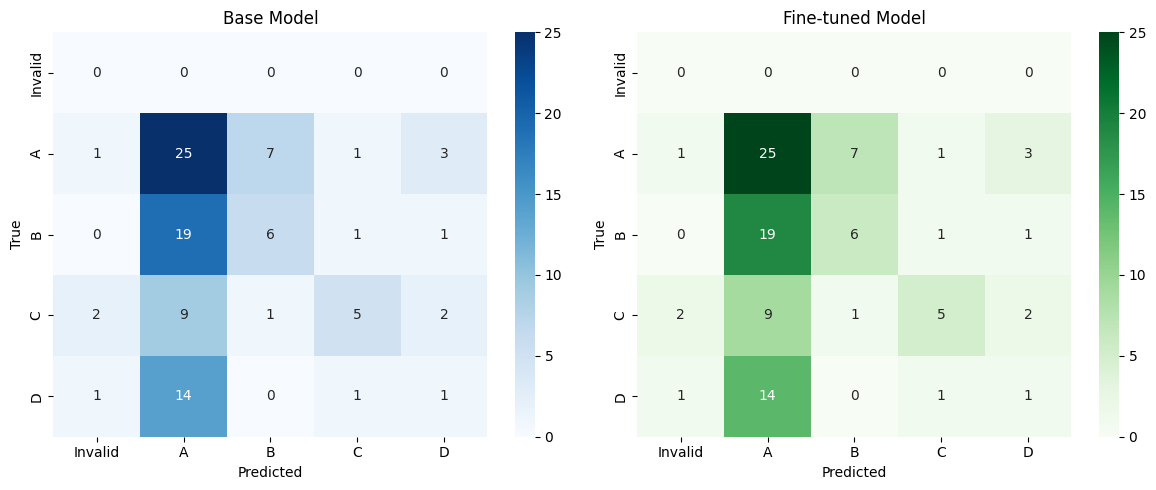

In [34]:
plot_confusion_matrices_side_by_side(
    metrics_base["confusion_matrix"], metrics_base["labels_all"], "Base Model",
    metrics_tuned["confusion_matrix"], metrics_tuned["labels_all"], "Fine-tuned Model"
)

**Nhận xét:**